In [1]:
import xcast as xc 
import xarray as xr 
import cartopy.crs as ccrs 

model = xr.open_dataset('data/MODEL_JJA.nc').prec
obs = xr.open_dataset('data/OBS_JJA.nc').precip.expand_dims({'M':[0]})

In [2]:
obs, model = xc.match(obs, model)

In [3]:
model = model.sel(longitude=slice(-120, -70), latitude=slice(20,60))
obs = obs.sel(longitude=slice(-120, -70), latitude=slice(20,60))

drymask = xc.drymask(obs, dry_threshold=30, quantile_threshold=0.3)
obs = obs*drymask 

hindcasts_det, hindcasts_prob = [], []
i=1
for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=3):
    print("window {}".format(i))
    i += 1
    reg = xc.ACPAC()
    reg.fit(xtrain, ytrain)
    probs =  reg.predict_proba(xtest)
    preds = reg.predict(xtest)
    hindcasts_det.append(preds.isel(time=1))
    hindcasts_prob.append(probs.isel(time=1))
hindcasts_det = xr.concat(hindcasts_det, 'time')
hindcasts_prob = xr.concat(hindcasts_prob, 'time')


window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24


In [4]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs)
T = ohc.transform(obs)
clim = xr.ones_like(T) * 0.333

In [5]:
clim_rps = xc.RankProbabilityScore(clim, T)
pred_rps = xc.RankProbabilityScore(hindcasts_prob, T)
rpss = 1 - pred_rps / clim_rps 

/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


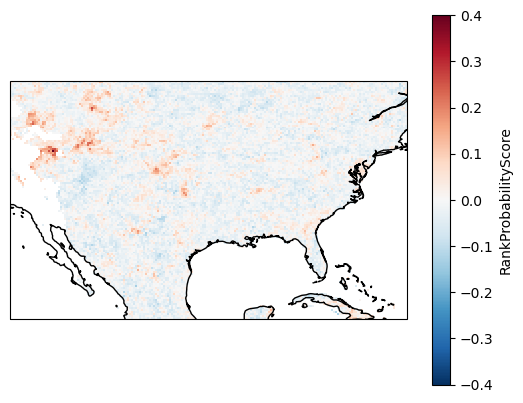

In [6]:
pl = rpss.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

In [7]:
pearson = xc.Pearson(hindcasts_det, obs)

/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


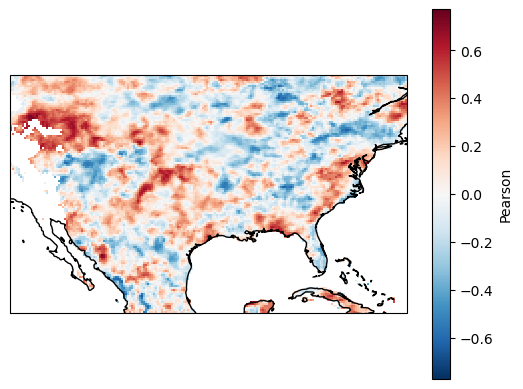

In [8]:
pl = pearson.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


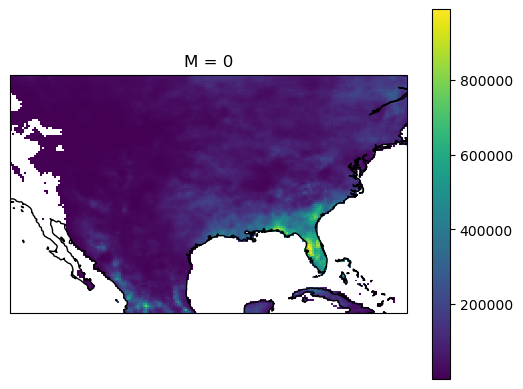

In [9]:
mse = ((obs - hindcasts_det)**2).mean('time')
pl = mse.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()